# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
songs = pd.read_csv('https://raw.githubusercontent.com/MerleSt/SpotifyPlaylistMoosic/main/Data/song_fatures_cleaned.csv', index_col=[0,1])

In [3]:
songs.shape

(5235, 13)

# Scale

Since we found a few outliers in the data preprocessing operation, we need to either use a scalar, which corrects for this, drop the data, or use a model with weights. A combination of all of those is possible as well. 
1. Dropping all data is not an ideal solution, since there are too many outliers
2. A scalar to use here could be the RObust Scaler which corrects for outliers
3. Weights can be attricuted according to the distance to the centroid, hence, points further away have a lower weight in the clustering. This can be implemented in the K-means model. Since we will evaluate the model later on, we should not just decide on one strategy yet, but implement multiple and compare the results.

## Robust Scaler

In [4]:
# Define the scaler, use it and then transform the data into a dataframe again
scaler = RobustScaler()
songs_scaled = scaler.fit_transform(songs)
songs_robust = pd.DataFrame(songs_scaled, columns=songs.columns, index=songs.index)

In [5]:
songs_robust.shape

(5235, 13)

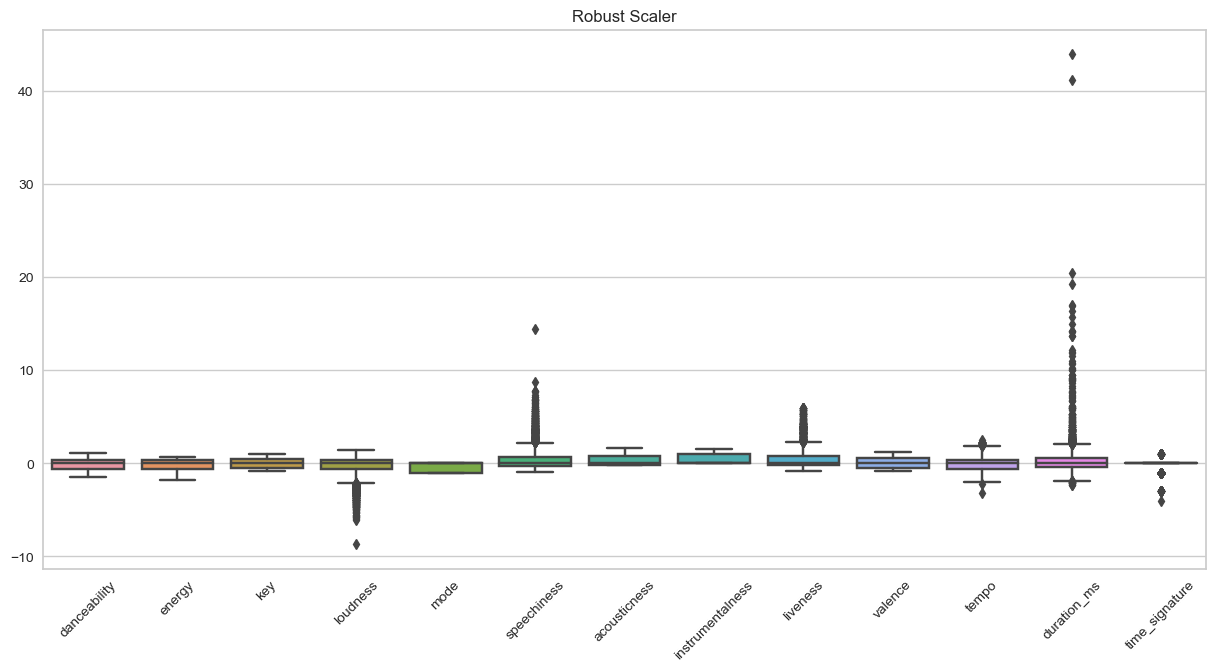

In [6]:
# Let us look at the outliers again
plt.figure(figsize=(15, 7))
sns.boxplot(data=songs_robust)
plt.title('Robust Scaler')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

## MinMax Scaler

In [7]:
scaler = MinMaxScaler()
songs_scaled = scaler.fit_transform(songs)
songs_minmax = pd.DataFrame(songs_scaled, columns=songs.columns, index=songs.index)

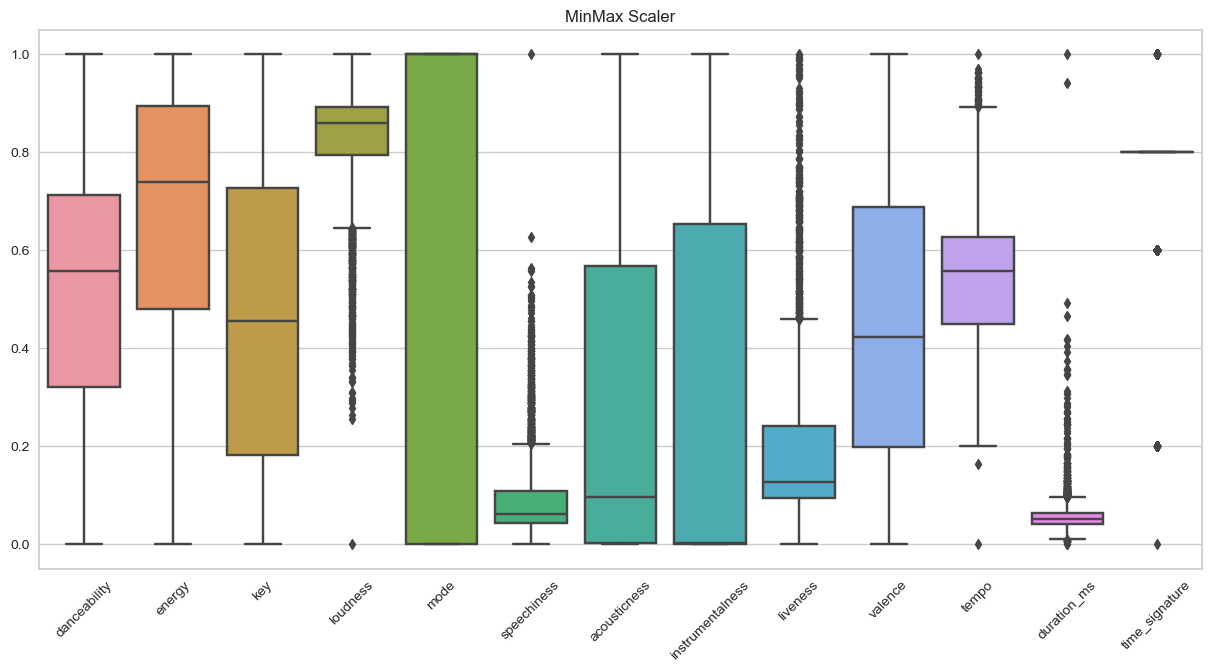

In [8]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=songs_minmax)
plt.title('MinMax Scaler')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

# Determine Number of Ks

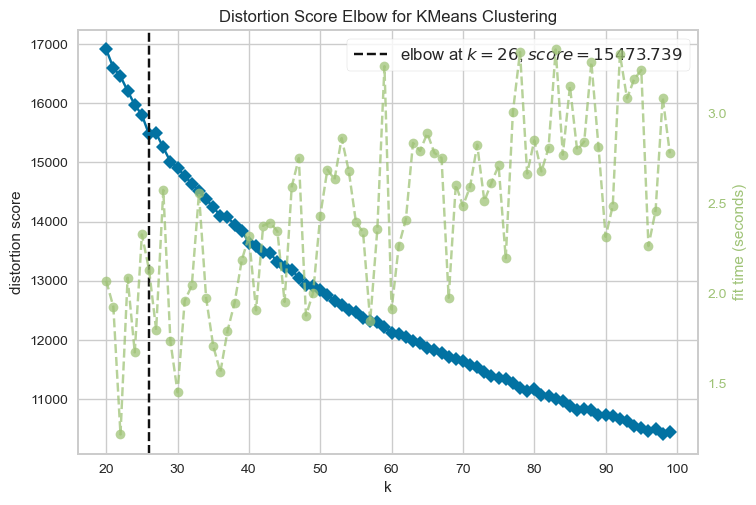

In [48]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init=10, random_state=213)
visualizer = KElbowVisualizer(model, k=(20,100))

visualizer.fit(songs_robust)        # Fit the data to the visualizer
visualizer.show();

In [10]:
k = visualizer.elbow_value_
print(f"The optimal number of clusters with a robust scaler is: {k}")

The optimal number of clusters with a robust scaler is: 11


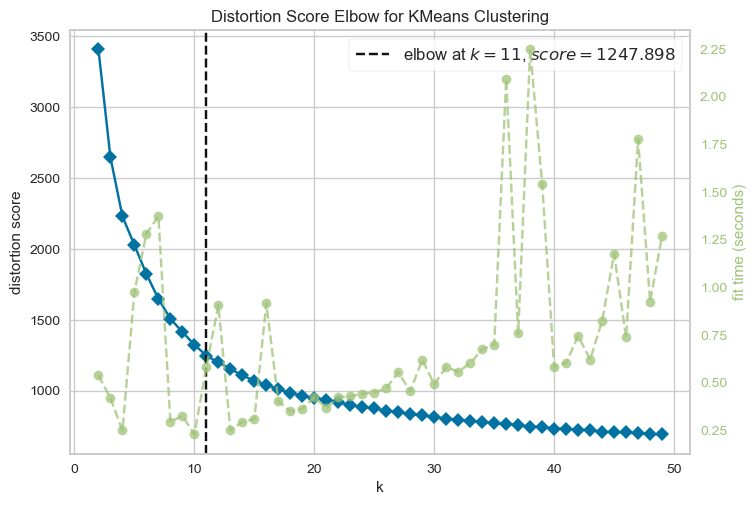

In [11]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init=10, random_state=213)
visualizer = KElbowVisualizer(model, k=(2,50))

visualizer.fit(songs_minmax)        # Fit the data to the visualizer
visualizer.show();

In [12]:
k = visualizer.elbow_value_
print(f"The optimal number of clusters with the minmax scaler is: {k}")

The optimal number of clusters with the minmax scaler is: 11


# K-Means

## Weighted K-Means

Let's say you would prefer the MinMax Scaler since it makes readability and explanations easier, but you do not want to drop all outliers. Another idea would be to implement weights to the oberservations. The further an pbservation from their cluster, the lower their weight. 

In [14]:
# Step 1: Initial K-means run
kmeans = KMeans(n_init=10, n_clusters=k, random_state=213) # adjust the number of clusters as needed
kmeans.fit(songs_minmax)
initial_centroids = kmeans.cluster_centers_

# Step 2: Compute distance of each sample to its closest centroid
songs_array = songs_robust.to_numpy()  # Convert DataFrame to numpy array
n_samples = songs_array.shape[0]

# Using broadcasting to compute distances
expanded_songs = songs_array[:, np.newaxis, :]
expanded_centroids = initial_centroids[np.newaxis, :, :]
distances_all = np.linalg.norm(expanded_songs - expanded_centroids, axis=2)
distances = np.min(distances_all, axis=1)

# Step 3: Assign weights inversely proportional to distances 
weights = 1.0 / (distances + 1e-10)

# Now, you can use these weights in K-means
kmeans_weighted = KMeans(n_init=10, n_clusters=k, random_state=213)
clusters = kmeans_weighted.fit_predict(songs_robust, sample_weight=weights)

songs_minmax['cluster'] = clusters

In [16]:
songs_minmax

,,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
name,artist,,,,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.680455,0.25900,1.000000,0.763897,0.0,0.076797,0.696787,0.000060,0.987842,0.310660,0.515800,0.059067,0.8,8
Saudade De Bahia,Antônio Carlos Jobim,0.767322,0.39900,0.181818,0.771967,1.0,0.037691,0.217871,0.000002,0.108409,0.703553,0.584322,0.042058,0.8,0
"Canta Canta, Minha Gente",Martinho Da Vila,0.880041,0.73000,0.181818,0.798018,1.0,0.377996,0.454819,0.000064,0.125633,0.918782,0.437862,0.031590,0.8,4
Mulher Eu Sei,Chico César,0.729059,0.05020,0.363636,0.682811,1.0,0.051307,0.882530,0.000041,0.391084,0.531980,0.499098,0.040567,0.8,0
Rosa Morena,Kurt Elling,0.673216,0.11900,0.545455,0.655228,1.0,0.041394,0.919679,0.000348,0.105370,0.408122,0.565171,0.063684,0.8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.208893,0.06940,0.272727,0.596818,1.0,0.051525,0.920683,0.725888,0.084296,0.066497,0.410795,0.254357,0.8,3
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.194416,0.10100,0.545455,0.621548,1.0,0.048148,0.858434,0.432487,0.070314,0.036041,0.388495,0.217350,0.8,3
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.061634,0.00093,0.818182,0.277803,1.0,0.047277,0.954819,0.983756,0.078217,0.034924,0.334469,0.054302,0.6,10


## Normal K-Means

### Robust Scaler

In [38]:
songs_only_robust = songs_robust.copy()

In [39]:
kmeans = KMeans(n_init=10, n_clusters=k, random_state=213)  # random_state for reproducibility
songs_only_robust['cluster'] = kmeans.fit_predict(songs_only_robust)

In [19]:
# Step 1: Merge the dataframes
merged_df = songs_robust[['cluster']].merge(songs_minmax[['cluster']], left_index=True, right_index=True, suffixes=('_robust', '_minmax'))

# Step 2: Create a contingency table
contingency_table = pd.crosstab(merged_df['cluster_robust'], merged_df['cluster_minmax'])

# Display the table
print(contingency_table)

cluster_minmax   0    1    2   3    4    5    6    7    8    9    10
cluster_robust                                                      
0                 1    0   78  34    0    0    0    0    1    0   59
1                 8   55    0   0   13   22  561   13    6    0    0
2                 0    0    0  41    0    0    0    0    0    0    0
3                 0    0    0   0    1    0    0    0  209    0    0
4                 1    0    0   0    0    0    0    0    0    0  449
5                22  233    3   0   24  604   10  732    0    4    0
6                 0   40    0   0   29   13    5    3    1  751    0
7                 0    6    0   0  397    1    0    0    0    1    0
8               545   30   31   0    1   35    2    5    0    0   48
9                 0    0    0   2    0    0    0    0    0    0    0
10                0    8  262   0    5    7    6    5    0   64    0


### MinMax Scaler

In [42]:
songs_only_minmax = songs_minmax.copy()

In [43]:
kmeans = KMeans(n_init=10, n_clusters=k, random_state=213)  # random_state for reproducibility
songs_only_minmax['cluster'] = kmeans.fit_predict(songs_only_minmax)

## Robust K-Means

In [25]:
from sklearn_extra.cluster import KMedoids

# Assuming you have your data in a DataFrame called songs_robust, without the cluster column
data = songs_robust.drop(columns='cluster', errors='ignore')


# Initialize and fit the model
kmedoids = KMedoids(n_clusters=k, metric='euclidean', init='heuristic', random_state=213)
songs_robust['cluster'] = kmedoids.fit_predict(data)

In [26]:
# Step 1: Merge the dataframes
merged_df = songs_robust[['cluster']].merge(songs_minmax[['cluster']], left_index=True, right_index=True, suffixes=('_robust', '_minmax'))

# Step 2: Create a contingency table
contingency_table = pd.crosstab(merged_df['cluster_robust'], merged_df['cluster_minmax'])

# Display the table
print(contingency_table)

cluster_minmax   0    1    2   3    4    5    6    7    8    9    10
cluster_robust                                                      
0                 7    4  257  65    0   14    0    1    0    0    0
1                37  135   11   0   11    0   13  166    0   12    0
2                22  203    0   0    6  119   14   35    0    9    0
3                 3    0   25  11    0    0    0    0    1    0  493
4               343    0   11   0    0    0    0    2    0    0   63
5                 0    2    5   0  381    1    2    0   19    2    0
6                 0   11   35   0   30    0   14    3    0  718    0
7               121    2    0   0    0  144  160  211    0    1    0
8                12    1    4   0   41  139   34  316    0    3    0
9                28   13    9   0    1  265   93   23    0   52    0
10                4    1   17   1    0    0  254    1  197   23    0


Let me use the songs_robust clusters from the Robust K-Means with the Robust Scaler from here on.

# Correlation Matrix of Features

Let us look at the correlation between features, as to decide whether we can drop columns and refine our model.

In [27]:
# Assuming songs_robust is your DataFrame
correlation_matrix = songs_robust[songs_robust.columns].corr()

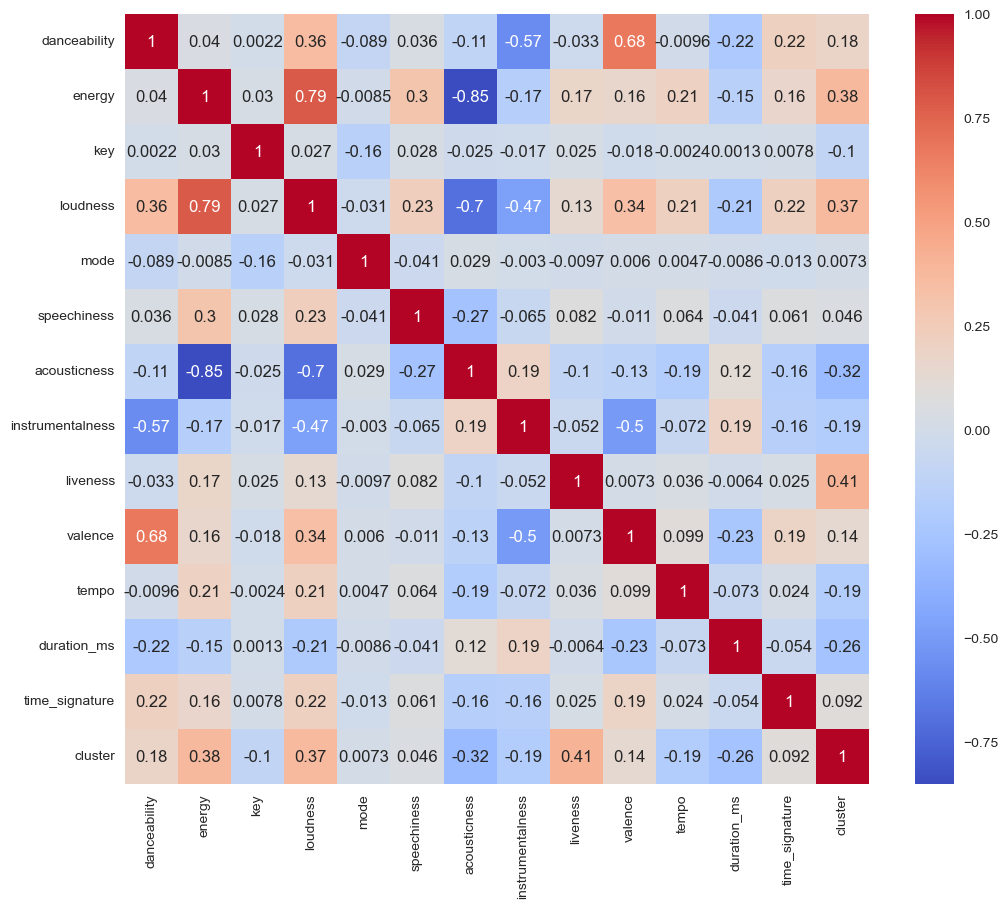

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Feature Importance

## Extra Trees Classifier

In [32]:
# Tree model classifiers
songs_without_cluster = songs_robust.drop('cluster', axis=1)
tree_model = ExtraTreesClassifier().fit(songs_without_cluster, clusters)
feature_importance = tree_model.feature_importances_

ranked_features = [x for _, x in sorted(zip(feature_importance, songs_without_cluster.columns), reverse=True)]
print("Ranked Features:", ranked_features)

Ranked Features: ['liveness', 'speechiness', 'acousticness', 'energy', 'instrumentalness', 'duration_ms', 'key', 'danceability', 'tempo', 'loudness', 'valence', 'mode', 'time_signature']


In [33]:
features_with_importance = sorted(list(zip(songs_without_cluster.columns, feature_importance)), key=lambda x: x[1], reverse=True)

for feature, importance in features_with_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: liveness, Importance: 0.1303022385380547
Feature: speechiness, Importance: 0.11477828985756255
Feature: acousticness, Importance: 0.1057258974426008
Feature: energy, Importance: 0.10015979243942798
Feature: instrumentalness, Importance: 0.087144313068431
Feature: duration_ms, Importance: 0.08547953035409545
Feature: key, Importance: 0.08385704972215562
Feature: danceability, Importance: 0.0770862059090042
Feature: tempo, Importance: 0.07202122794067983
Feature: loudness, Importance: 0.0628325769555247
Feature: valence, Importance: 0.05637100043808571
Feature: mode, Importance: 0.015439471426413871
Feature: time_signature, Importance: 0.008802405907963726


## Correlation Matrix of Features

Let us look at the correlation between features, as to decide whether we can drop columns and refine our model.

In [27]:
# Assuming songs_robust is your DataFrame
correlation_matrix = songs_robust[songs_robust.columns].corr()

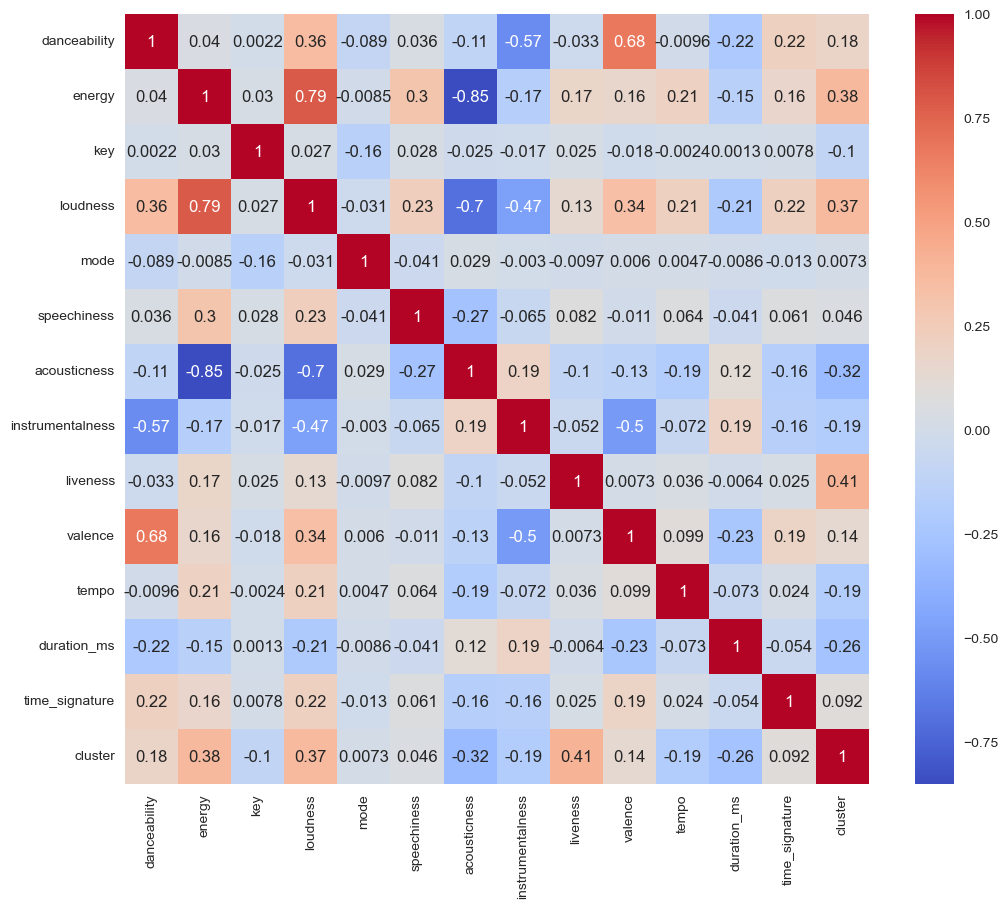

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Evaluating the Model

## Silhouette Score

Definition: The Silhouette Score measures how close each point in one cluster is to the points in the neighboring clusters.

In [34]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_robust, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  0.06314803756900958


In [40]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_only_robust, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  0.2881981215360579


In [44]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_only_minmax, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  0.40863867636279355


In [35]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_minmax, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  0.02000428170537565


## Davies-Bouldin Index

The Davies-Bouldin index signifies the average 'similarity' ratio of each cluster with its most similar cluster. Here, 'similarity' is a measure that compares the distance between clusters with the size of the clusters themselves.

In [36]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_robust, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  1.8687894964475866


In [41]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_only_robust, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  1.1394294782546344


In [45]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_only_minmax, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  1.0886990520953466


In [37]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_minmax, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  3.9496025778166794


The best model so far is the Normal K-Means using the MinMax Scaler

# Improving the Model

In [47]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Assuming your data is in songs_robust without the 'cluster' column
X = songs_only_minmax.drop('cluster', axis=1)

# Initial clustering and silhouette score
kmeans = KMeans(n_init=10, n_clusters=k, random_state=213)  # or however many clusters you want
initial_clusters = kmeans.fit_predict(X)
initial_silhouette = silhouette_score(X, initial_clusters)

print(f"Initial Silhouette Score: {initial_silhouette}")

# Store silhouette scores after dropping each feature
drop_scores = {}

for feature in X.columns:
    # Drop the feature
    X_dropped = X.drop(feature, axis=1)
    
    # Perform clustering on reduced data
    clusters_dropped = kmeans.fit_predict(X_dropped)
    
    # Compute silhouette score without the feature
    silhouette_dropped = silhouette_score(X_dropped, clusters_dropped)
    
    # Store the result
    drop_scores[feature] = silhouette_dropped
    
    print(f"Silhouette Score without {feature}: {silhouette_dropped}")

# After the loop, you can compare drop_scores with initial_silhouette 
# to make decisions about which features to keep/drop


Initial Silhouette Score: 0.2592139859003715
Silhouette Score without danceability: 0.2711817694052898
Silhouette Score without energy: 0.26785550081851994
Silhouette Score without key: 0.3055200227191694
Silhouette Score without loudness: 0.26195619566524747
Silhouette Score without mode: 0.1936323791460497
Silhouette Score without speechiness: 0.2633158936703703
Silhouette Score without acousticness: 0.245025865298712
Silhouette Score without instrumentalness: 0.24075203455089134
Silhouette Score without liveness: 0.274849499992904
Silhouette Score without valence: 0.29625549181173955
Silhouette Score without tempo: 0.2735349337373394
Silhouette Score without duration_ms: 0.26028961751448276
Silhouette Score without time_signature: 0.2646308451561721
